161


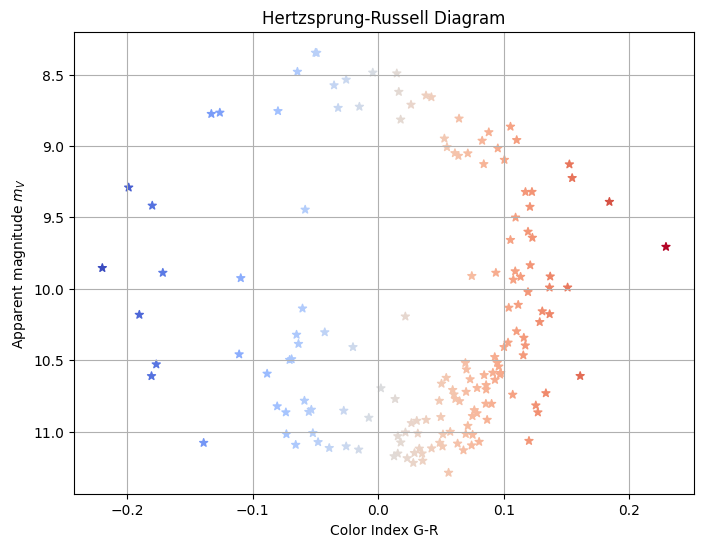

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry

default_zero_point = 25.0  # Default magnitude zero point if not available in FITS header
# Load FITS file and check the header
def load_fits_image(filename):
    with fits.open(filename) as hdul:
        data = hdul[0].data  # Main image
        header = hdul[0].header
        mag_zero_point = header.get("MAGZP", default_zero_point)  # Get magnitude zero point if available
    return data, mag_zero_point


def find_stars(image, threshold=5):
    mean, std = np.mean(image), np.std(image)
    star_finder = DAOStarFinder(fwhm=3, threshold=threshold * std)
    stars = star_finder(image - mean)
    
    # Filter out stars where the intensity is greater than 60000
    valid_stars = []
    for star in stars:
        x, y = int(star['xcentroid']), int(star['ycentroid'])
        if image[y, x] <= 64000:
            valid_stars.append(star)
    
    return valid_stars

# Compute integrated intensity for each star
def compute_intensity(image, stars, radius=10):
    # positions = np.transpose((stars['xcentroid'], stars['ycentroid']))
    positions = [(star['xcentroid'], star['ycentroid']) for star in stars]
    apertures = CircularAperture(positions, r=radius)
    phot_table = aperture_photometry(image, apertures)
    return phot_table['aperture_sum']

# Main processing function
def process_fits(filename):
    image, mag_zero_point = load_fits_image(filename)
    if len(image.shape) == 3:
        stars = find_stars(image[1])  # Use the G channel to detect stars
        print(len(stars))
        intensities = []
        for i in range(len(stars)):
            star_intensity = []
            for channel in range(3):
                intensity = compute_intensity(image[channel], stars)[i]
                star_intensity.append(intensity)
            intensities.append(tuple(star_intensity))
        return intensities, mag_zero_point
    else:
        print("Error: The image does not contain RGB color channels.")
        return None, None

# Run the program
# fits_filename = '/Users/Alexey_Pasechnik/Pictures/Seestar/MyWorks/M 13/M 13_crop_calibrated.fit'
fits_filename = '/Users/Alexey_Pasechnik/Pictures/Seestar/MyWorks/M 45_mosaic/Stacked_361_mosaic_M 45_10.0s_IRCUT_20241102-215037.fit'
intensity_results, mag_zero_point = process_fits(fits_filename)
# print (fits.info(fits_filename))

# Convert RGB to G-R and M_V
G_R = [2 * (g - r) / (g + r) for r, g, b in intensity_results]
M_V = [-2.5 * np.log10(r + g + b) + mag_zero_point for r, g, b in intensity_results]

# Define colormap based on G-R index
colors = plt.cm.coolwarm((np.array(G_R) - min(G_R)) / (max(G_R) - min(G_R)))

# Plot Hertzsprung-Russell diagram
plt.figure(figsize=(8, 6))
plt.scatter(G_R, M_V, c=colors, marker='*')
plt.gca().invert_yaxis()  # Invert Y-axis as brighter stars have lower magnitudes
plt.xlabel("Color Index G-R")
plt.ylabel("Apparent magnitude $m_V$")
plt.title("Hertzsprung-Russell Diagram")
plt.grid()
plt.show()

